In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
zed_stamps = os.listdir('/root/itlp_campus_data/front_cam')
zed_stamps = [int(x.split('.')[0]) for x in zed_stamps]
zed_stamps.sort()

In [3]:
realsense_stamps = os.listdir('/root/itlp_campus_data/back_cam')
realsense_stamps = [int(x.split('.')[0]) for x in realsense_stamps]
realsense_stamps.sort()

In [4]:
lidar_stamps = os.listdir('/root/itlp_campus_data/lidar')
lidar_stamps = [int(x.split('.')[0]) for x in lidar_stamps]
lidar_stamps.sort()

In [5]:
pose_stamps = os.listdir('/root/itlp_campus_data/pose')
pose_stamps = [int(x.split('.')[0]) for x in pose_stamps]
pose_stamps.sort()

In [6]:
print(len(realsense_stamps), len(zed_stamps), len(lidar_stamps), len(pose_stamps))

5858 3883 3880 3880


In [7]:
def find_nearest_stamp(stamps, i, ref_stamp):
    if i == 0:
        return stamps[0]
    if i >= len(stamps):
        return stamps[-1]
    if ref_stamp - stamps[i - 1] < stamps[i] - ref_stamp:
        return stamps[i - 1]
    return stamps[i]

In [8]:
zed_stamps[:10]

[1678707990789881,
 1678707990873259,
 1678707990973261,
 1678707991073267,
 1678707991173268,
 1678707991289885,
 1678707991389883,
 1678707991473264,
 1678707991573260,
 1678707991673253]

In [9]:
realsense_stamps[:10]

[1678707990788672,
 1678707990855525,
 1678707990922382,
 1678707990989263,
 1678707991055904,
 1678707991122543,
 1678707991189182,
 1678707991255819,
 1678707991322455,
 1678707991389089]

In [10]:
i_zed = 0
i_rs = 0
i_lidar = 0
timestamps = []
front_cam_ts = []
back_cam_ts = []
lidar_ts = []
poses = []
for i in range(len(pose_stamps)):
    while i_zed < len(zed_stamps) and zed_stamps[i_zed] < pose_stamps[i]:
        i_zed += 1
    while i_rs < len(realsense_stamps) and realsense_stamps[i_rs] < pose_stamps[i]:
        i_rs += 1
    while i_lidar < len(lidar_stamps) and lidar_stamps[i_lidar] < pose_stamps[i]:
        i_lidar += 1
    zed_stamp = find_nearest_stamp(zed_stamps, i_zed, pose_stamps[i])
    realsense_stamp = find_nearest_stamp(realsense_stamps, i_rs, pose_stamps[i])
    lidar_stamp = find_nearest_stamp(lidar_stamps, i_lidar, pose_stamps[i])
    position = np.loadtxt('/root/itlp_campus_data/pose/{}.txt'.format(pose_stamps[i]))
    timestamps.append(pose_stamps[i])
    front_cam_ts.append(zed_stamp)
    back_cam_ts.append(realsense_stamp)
    lidar_ts.append(lidar_stamp)
    poses.append(position)

In [11]:
timestamps = np.array(timestamps).astype(np.int64)
front_cam_ts = np.array(front_cam_ts).astype(np.int64)
back_cam_ts = np.array(back_cam_ts).astype(np.int64)
lidar_ts = np.array(lidar_ts).astype(np.int64)
poses = np.array(poses)
data = np.hstack([
    timestamps[:, np.newaxis],
    front_cam_ts[:, np.newaxis],
    back_cam_ts[:, np.newaxis],
    lidar_ts[:, np.newaxis],
    poses
])
data.shape

(3880, 11)

In [12]:
df = pd.DataFrame(data, columns=['timestamp', 'front_cam_ts', 'back_cam_ts', 'lidar_ts', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
df.timestamp = df.timestamp.astype(np.int64)
df.front_cam_ts = df.front_cam_ts.astype(np.int64)
df.back_cam_ts = df.back_cam_ts.astype(np.int64)
df.lidar_ts = df.lidar_ts.astype(np.int64)

In [13]:
df.to_csv('/root/itlp_campus_data/track.csv')

In [14]:
from tqdm import tqdm_notebook
from PIL import Image
import argparse
from pathlib import Path
from typing import Tuple
import cv2
zed_dir = '/root/itlp_campus_data/front_cam'
realsense_dir = '/root/itlp_campus_data/back_cam'
lidar_dir = '/root/itlp_campus_data/lidar'

In [15]:
semantic_dir = '/root/itlp_campus_data/labels/front_cam'
filenames = os.listdir(semantic_dir)
for fn in filenames[100:101]:
    sem_mask = Image.open(os.path.join(semantic_dir, fn))
    sem_mask = np.asarray(sem_mask)
    print(sem_mask.min(), sem_mask.max())

0 138


In [16]:
np.unique(sem_mask)

array([  0,   3,   5,   8,  14,  41,  82, 138], dtype=uint8)

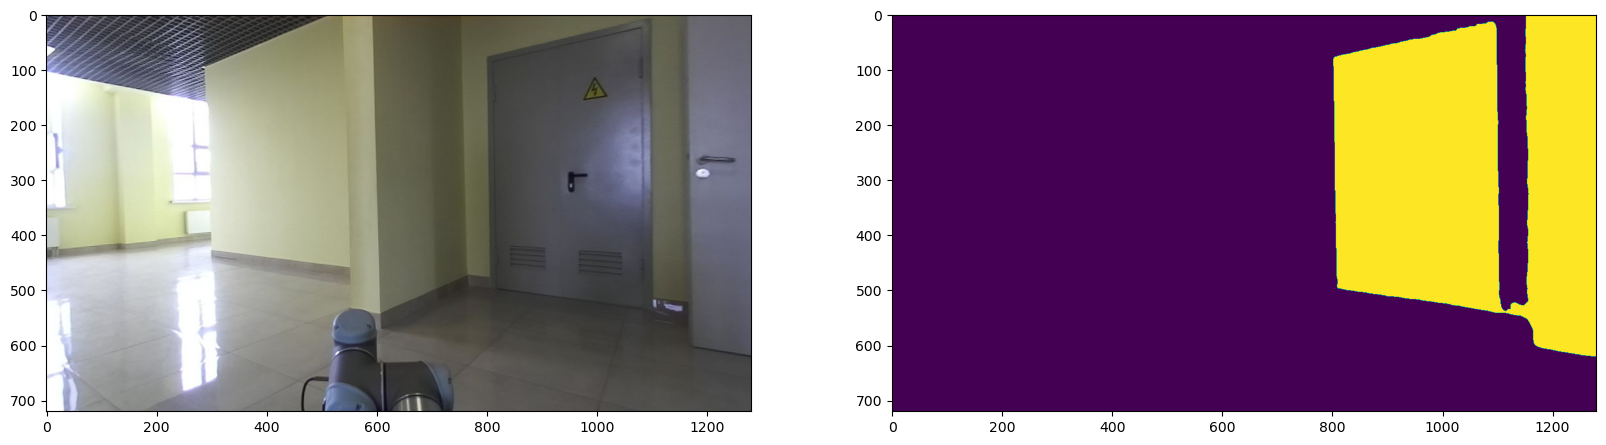

In [17]:
img = Image.open(os.path.join('/root/itlp_campus_data/front_cam', fn))
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow((sem_mask == 14))

In [26]:
def draw_track_map(
    current_pose: np.ndarray, all_utms: np.ndarray, size: Tuple[int, int] = (540, 540)
) -> np.ndarray:
    x, y = all_utms[:, 0], all_utms[:, 1]
    cur_x, cur_y = current_pose[0], current_pose[1]
    fig, ax = plt.subplots(dpi=200)
    ax.plot(x, y, lw=3, ls=':', color="blue")
    ax.scatter(cur_x, cur_y, s=50, color="red")
    #ax.set_xlabel("x")
    ax.set_xlim(-10, 100)
    ax.set_xticks([])
    #ax.set_ylabel("y")
    ax.set_ylim(-16, -1.5)
    ax.set_yticks([])
    #ax.set_aspect("equal", adjustable="box")
    fig.canvas.draw()
    # convert canvas to image
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    # convert from RGB to BGR for OpenCV
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = center_crop(img, (960, 740))
    img = cv2.resize(img, size)
    return img

In [27]:
def load_pc(filepath: Path) -> np.ndarray:
    pc = np.fromfile(filepath, dtype=np.float32).reshape((-1, 4))[:, :-1]
    pc = pc[~np.isnan(pc).any(axis=1)]
    return pc

In [28]:
def draw_pointcloud(pc: np.ndarray, size: Tuple[int, int] = (540, 540)) -> np.ndarray:
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection="3d")
    # Set limits for x, y, and z axes
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-1, 3])
    # Calculate distance of each point from origin
    dist = np.sqrt(np.sum(np.square(pc), axis=1))
    # Normalize distance values to [0, 1] range
    norm = plt.Normalize(dist.min(), dist.max())
    colors = plt.cm.jet(norm(dist))
    # Plot point cloud with color based on distance from origin
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.1, c=colors)
    # Fix the viewpoint
    ax.view_init(elev=45, azim=-180)
    # Hide axes
    ax.set_axis_off()
    # Add tight layout
    plt.tight_layout()
    # Convert plot to cv2 image
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    img = center_crop(img, (960, 960))
    img = cv2.resize(img, size)
    plt.close(fig)
    return img

In [29]:
def center_crop(img, dim):
    """Returns center cropped image
    Args:
    img: image to be center cropped
    dim: dimensions (width, height) to be cropped
    """
    width, height = img.shape[1], img.shape[0]

    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0] < img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1] < img.shape[0] else img.shape[0]
    mid_x, mid_y = int(width / 2), int(height / 2)
    cw2, ch2 = int(crop_width / 2), int(crop_height / 2)
    crop_img = img[mid_y - ch2 : mid_y + ch2, mid_x - cw2 : mid_x + cw2]
    return crop_img

In [30]:
def make_frame(
    img_front: np.ndarray, img_back: np.ndarray, img_lidar: np.ndarray, img_map: np.ndarray
) -> np.ndarray:
    frame = np.full((1080, 1920, 3), fill_value=255, dtype=np.uint8)
    frame[40:520, 40:894] = img_front
    frame[560:1040, 40:894] = img_back
    frame[0:540, 1200:1740] = img_lidar
    frame[690:930, 1080:1800] = img_map
    return frame

In [31]:
video_name = '/root/itlp_campus_data/demo.mp4'
fps = 3
frame_size = (1920, 1080)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(video_name, fourcc, fps, frame_size)

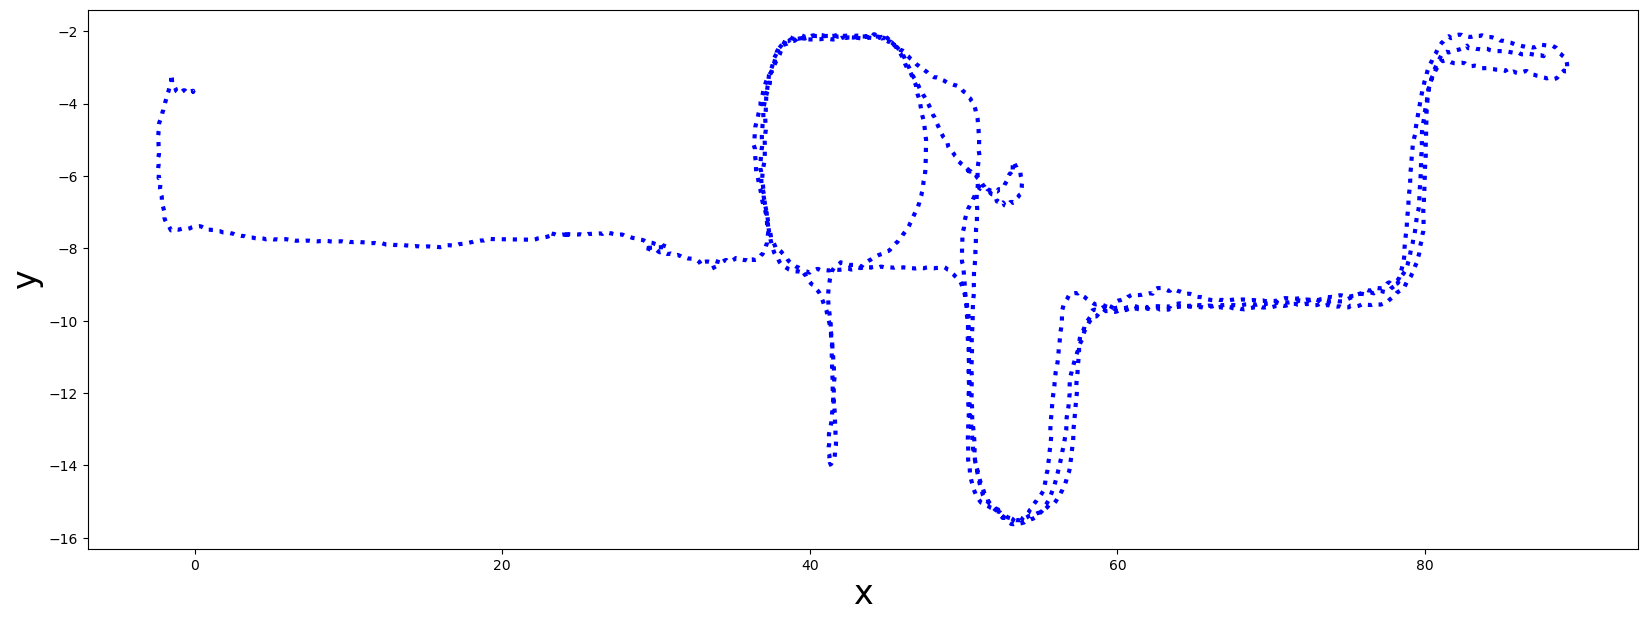

In [36]:
plt.figure(figsize=(20, 7))
plt.plot(poses[:, 0], poses[:, 1], lw=3, ls=':', color='b')
plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.savefig('track_map.png')

In [32]:
track_map = draw_track_map(poses[0, :2], poses[:, :2], size=(720, 240))
track_map = Image.fromarray(track_map)
track_map.save('track_map.png')

In [ ]:
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
for i in tqdm_notebook(range(0, len(front_cam_ts), 5)):
    plt.figure(figsize=(20, 13))
    zed_image = Image.open(os.path.join(zed_dir, '{}.png'.format(front_cam_ts[i])))
    zed_image = np.asarray(zed_image)
    zed_image = cv2.resize(zed_image[:, :, :3], (854, 480))
    realsense_image = Image.open(os.path.join(realsense_dir, '{}.png'.format(back_cam_ts[i])))
    realsense_image = np.asarray(realsense_image)
    realsense_image = cv2.resize(realsense_image[:, :, :3], (854, 480))
    pcd_image = draw_pointcloud(load_pc(os.path.join(lidar_dir, '{}.bin'.format(lidar_ts[i]))))
    track_image = draw_track_map(poses[i, :2], poses[:, :2], size=(720, 240))
    frame = make_frame(zed_image, realsense_image, pcd_image, track_image)
    out.write(frame)
out.release()

In [ ]:
np.unique(semantic_mask)

In [ ]:
colors = np.zeros((255, 3))
colors[0] = [120, 120, 120]
colors[3] = [6, 230, 230]
colors[5] = [120, 120, 80]
colors[8] = [230, 230, 230]
colors[14] = [8, 255, 51]
colors[27] = [220, 220, 220]
#colors[97] = [255, 153, 0]
colors[110] = [0, 214, 255]
colors[148] = [102, 255, 0]

In [ ]:
img = Image.open('/root/itlp_campus_data/front_cam/1678708041509745.png')
img = np.asarray(img)
semantic_mask = Image.open('/root/itlp_campus_data/labels/front_cam/1678708041509745.png')
semantic_mask = np.asarray(semantic_mask)
sem_mask_colored = np.zeros((semantic_mask.shape[0], semantic_mask.shape[1], 3))
for c in np.unique(semantic_mask):
    sem_mask_colored[semantic_mask == c] = colors[c]
plt.figure(figsize=(24, 14))
plt.imshow((img.astype(float) / 255) * 0.5 + (sem_mask_colored.astype(float) / 255) * 0.5)
plt.xticks([])
plt.yticks([])
plt.savefig('sem_mask.png')

In [ ]:
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(0, data.shape[0], 5)):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.xticks([])
    plt.yticks([])
    zed_image = Image.open(os.path.join(zed_dir, '{}.png'.format(front_cam_ts[i])))
    plt.imshow(zed_image)
    plt.subplot(2, 2, 2)
    plt.plot(poses[:, 0], poses[:, 1], color='b', lw=3, ls=':')
    plt.xlabel('x', fontsize=32)
    plt.ylabel('y', fontsize=32)
    plt.subplot(2, 2, 3)
    plt.xticks([])
    plt.yticks([])
    realsense_image = Image.open(os.path.join(realsense_dir, '{}.png'.format(back_cam_ts[i])))
    plt.imshow(realsense_image)
    plt.subplot(2, 2, 4)
    plt.plot(poses[:, 0], poses[:, 1], color='b', lw=3, ls=':')
    plt.scatter([poses[i, 0]], [poses[i, 1]], color='r', s=60)
    plt.xlabel('x', fontsize=32)
    plt.ylabel('y', fontsize=32)
    break